Setting refAnt: CS201HBA1
Loaded 15 antennas, 3595 times, 15 directions
Setting refAnt: CS201HBA1
Setting refAnt: CS201HBA1
Using radio array Radio Array: 1.50000e+08 MHz, Longitude 6.78 deg Latitude 52.91 deg Height -21.88 m
Using phase center 217.63756861111108 deg 34.57362555555555 deg
Fixing frame at 2014-08-10T13:00:00.000
Elevation is 46.13413688432986 deg
Sun at zenith angle 40.708514731932155
Creating ionosphere model...
Found domain u in -190.36769463747095..187.1178897953209, v in -202.787010398027..200.55735004804387, w in -129.70595242135474..1109.778064955974
Nx=76 Ny=81 Nz=248 number of cells: 1526688
Calculating rays...
Casting rays: 225
splitting over directions
Doing random numerical check
Numerical gradient[35,42,52] = -7123.102582991123, calculated = -6908.54387863805
Numerical gradient[35,43,26] = -11.675111018121243, calculated = -11.319047843138168
Numerical gradient[34,45,73] = 30515.411580447108, calculated = 29577.078511890642
Numerical gradient[36,44,159] = -1

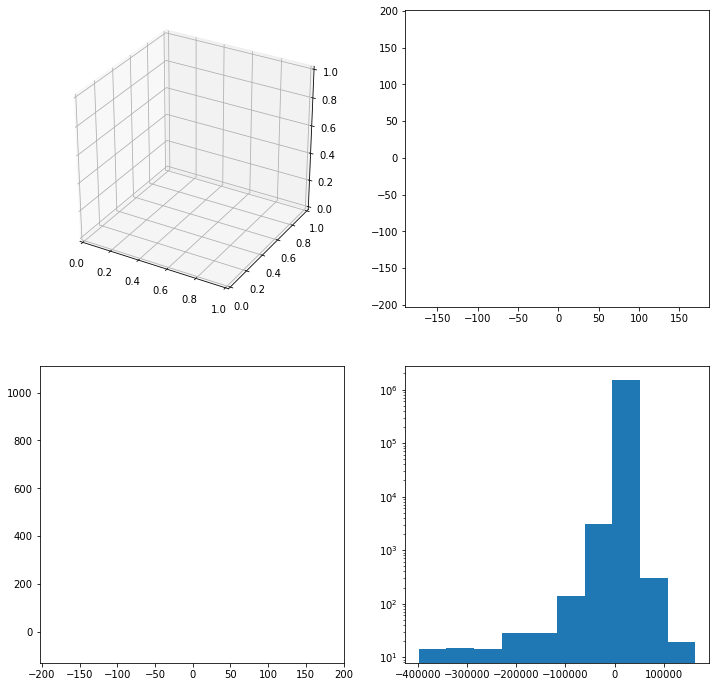

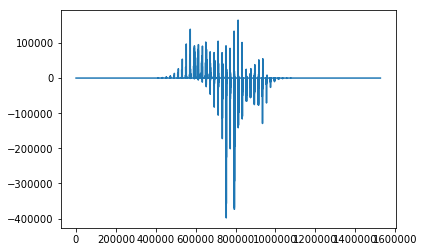

Using linear scaling
plotting levels : [-397932.30126091       0.          164508.63251934]


C:\Users\josh\Anaconda3\envs\compute\lib\site-packages\matplotlib\contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


In [4]:
'''The gradient for steepest direction, i.e. <Cm, d/dm(-log(posterior))> 
is equal to Adjoint(G).(g(m) - d_obs) + (m - m_prior) = Cm.G^t.Cd^-1 .( g(m) - d_obs ) + (m - m_prior)'''

from Bisect import bisect
import numpy as np
from scipy.integrate import simps
import dask.array as da
from dask import delayed
from dask.multiprocessing import get
from Covariance import CovarianceClass

def doGradientAdjoint(rays, dd, K_ne, mTCI, sigma_m, Nkernel, sizeCell, i0):
    #print("Doing gradient")
    L_m = Nkernel*sizeCell
    #if antennas parallelization Nt,Nd
    #if directions parallelization Na,Nd
    N1,N2,_,Ns = rays.shape
    mShape = [N1,N2,mTCI.nx,mTCI.ny,mTCI.nz]
    grad = np.zeros([mTCI.nx,mTCI.ny,mTCI.nz],dtype=np.double)
    
    mask = np.zeros(mShape, dtype=np.bool)
    idxMin = np.ones(mShape,dtype=np.int64)*Ns
    idxMax = np.ones(mShape,dtype=np.int64)*-1
    nevec = np.zeros([N1,N2,Ns],dtype=np.double)
    #go through the mask
#     X,Y,Z = np.meshgrid(np.arange(mTCI.xvec.size),
#                         np.arange(mTCI.yvec.size),
#                         np.arange(mTCI.zvec.size),indexing='ij')
    j = 0
    while j < N1:
        k = 0
        while k < N2:
            x_ray = rays[j,k,0,:]
            y_ray = rays[j,k,1,:]
            z_ray = rays[j,k,2,:]
            s_ray = rays[j,k,3,:]
            idx = 0
            while idx < Ns:
                nevec[j,k,idx] = K_ne*np.exp(mTCI.interp(x_ray[idx],y_ray[idx],z_ray[idx]))/1e13
                xi,yi,zi = bisect(mTCI.xvec,x_ray[idx]),bisect(mTCI.yvec,y_ray[idx]),bisect(mTCI.zvec,z_ray[idx])
                localMask = (j,k,slice(max(0,xi - Nkernel), min(mTCI.nx - 1, xi + Nkernel + 1)),
                            slice(max(0,yi - Nkernel) , min(mTCI.ny - 1,yi + Nkernel + 1)),
                            slice(max(0, zi - Nkernel), min(mTCI.nz - 1, zi + Nkernel + 1)))
                mask[localMask] = True
                shape = mask[localMask].shape
                idxMax[localMask] = np.max(np.stack([idxMax[localMask],
                                                     np.ones(shape,dtype=np.int64)*idx],axis=-1),axis=-1)
                #print(idxMax[localMask])
                idxMin[localMask] = np.min(np.stack([idxMin[localMask],
                                                     np.ones(shape,dtype=np.int64)*idx],axis=-1),axis=-1)
                idx += 1   
            k += 1
        j += 1
    
    sumMask = np.sum(np.sum(mask,axis=0),axis=0)
    xi = 0
    while xi < mTCI.nx:
        yi = 0
        while yi < mTCI.ny:
            zi = 0
            while zi < mTCI.nz:
                if not sumMask[xi,yi,zi]:
                    zi += 1
                    continue
                x,y,z = mTCI.xvec[xi],mTCI.yvec[yi],mTCI.zvec[zi]
                j = 0
                while j < N2:
                    i = 0
                    while i < N1:
                        x_ray = rays[i,j,0,:]
                        y_ray = rays[i,j,1,:]
                        z_ray = rays[i,j,2,:]
                        s_ray = rays[i,j,3,:]
                        ne = nevec[i,j,:]
                        if mask[i,j,xi,yi,zi]:
                            segmentMask = (slice(idxMin[i,j,xi,yi,zi],idxMax[i,j,xi,yi,zi]+1),)
                            dx = x - x_ray[segmentMask]
                            dy = y - y_ray[segmentMask]
                            dz = z - z_ray[segmentMask]
                            Cm = dx**2
                            dy *= dy
                            dz *= dz
                            Cm += dy
                            Cm += dz
                            #np.sqrt(Cm,out=Cm)
                            Cm /= -2.*L_m**2
                            np.exp(Cm,out=Cm)
                            Cm *= sigma_m**2
                            Cm *= ne[segmentMask]
                            comp = simps(Cm*dd[i,j],s_ray[segmentMask])
                            grad[xi,yi,zi] += comp
                            if i == i0:
                                grad[xi,yi,zi] -= N1*comp
                            
                        i += 1
                    j += 1
                zi += 1
            yi += 1
        xi += 1
    return grad
 
    
                
          
def computeAdjoint_dask(rays, g, dobs, i0, K_ne, mTCI, mPrior, CdCt, sigma_m, Nkernel, sizeCell):
    L_m = Nkernel*sizeCell
#     #i not eq i0 mask
#     mask = np.ones(rays.shape[0],dtype=np.bool)
#     mask[i0] = False
#     rays = rays[mask,:,:,:,:]
#     g = g[mask,:,:]
#     dobs = dobs[mask,:,:]
#     CdCt = CdCt[mask,:,:]
    #residuals
    #g.shape, dobs.shape [Na,Nt,Nd]
    dd = g - dobs
    #weighted residuals
    #Cd.shape [Na,Nt,Nd] i.e. diagonal
    #CdCt^-1 = 1./CdCt
    dd /= (CdCt + 1e-15)
    #get ray info
    Na, Nt, Nd, _ ,Ns = rays.shape
    #parallelize over directions
    gradient = da.sum(da.stack([da.from_delayed(delayed(doGradientAdjoint)(rays[:,:,d,:,:], dd[:,:,d], K_ne, mTCI, 
                                      sigma_m, Nkernel, sizeCell, i0),(mTCI.nx,mTCI.ny,mTCI.nz),dtype=np.double) for d in range(Nd)],axis=-1),axis=-1)
    gradient = gradient.compute(get=get)
    gradient += mTCI.getShapedArray()
    gradient -= mPrior
    
    #now Cm^-1.gradient
    gradient /= 8.*np.pi*sigma_m**2*L_m
    lapx = (gradient[1:,:-1,:-1] - gradient[:-1,:-1,:-1])/(mTCI.xvec[1] - mTCI.xvec[0])
    lapx *= lapx
    lapy = (gradient[:-1,1:,:-1] - gradient[:-1,:-1,:-1])/(mTCI.yvec[1] - mTCI.yvec[0])
    lapy *= lapy
    lapz = (gradient[:-1,:-1,1:] - gradient[:-1,:-1,:-1])/(mTCI.zvec[1] - mTCI.zvec[0])
    lapz *= lapz
    lapx += lapy
    lapx += lapz
    lapx *= 2
    gradient /= L_m**2
    gradient[:-1,:-1,:-1] -= lapx
    
    return gradient

def computeGradientAdjoint(rays, g, dobs, i0, K_ne, mTCI, mPrior, CdCt, sigma_m, Nkernel, sizeCell):
    L_m = Nkernel*sizeCell
#     #i not eq i0 mask
#     mask = np.ones(rays.shape[0],dtype=np.bool)
#     mask[i0] = False
#     rays = rays[mask,:,:,:,:]
#     g = g[mask,:,:]
#     dobs = dobs[mask,:,:]
#     CdCt = CdCt[mask,:,:]
    #residuals
    #g.shape, dobs.shape [Na,Nt,Nd]
    dd = g - dobs
    #weighted residuals
    #Cd.shape [Na,Nt,Nd] i.e. diagonal
    #CdCt^-1 = 1./CdCt
    dd /= (CdCt + 1e-15)
    #get ray info
    Na, Nt, Nd, _ ,Ns = rays.shape
#     if Na < Nd:
#         #parallelize over antennas
#         gradient = np.sum(np.stack([doGradient(rays[i,:,:,:,:], dd[i,:,:], K_ne, mTCI, 
#                                           sigma_m, Nkernel, sizeCell) for i in range(Na)],axis=-1),axis=-1)
#     else:
#         #parallelize over directions
#         gradient = np.sum(np.stack([doGradient(rays[:,:,d,:,:], dd[:,:,d], K_ne, mTCI, 
#                                          sigma_m, Nkernel, sizeCell) for d in range(Nd)],axis=-1),axis=-1)

    #parallelize over directions
    gradient = np.sum(np.stack([doGradientAdjoint(rays[:,:,d,:,:], dd[:,:,d], K_ne, mTCI, 
                                           sigma_m, Nkernel, sizeCell,i0) for d in range(Nd)],axis=-1),axis=-1)
              
    gradient += mTCI.getShapedArray()
    gradient -= mPrior
    
    gradient /= 8.*np.pi*sigma_m**2*L_m
    lapx = (gradient[1:,:-1,:-1] - gradient[:-1,:-1,:-1])/(mTCI.xvec[1] - mTCI.xvec[0])
    lapx *= lapx
    lapy = (gradient[:-1,1:,:-1] - gradient[:-1,:-1,:-1])/(mTCI.yvec[1] - mTCI.yvec[0])
    lapy *= lapy
    lapz = (gradient[:-1,:-1,1:] - gradient[:-1,:-1,:-1])/(mTCI.zvec[1] - mTCI.zvec[0])
    lapz *= lapz
    lapx += lapy
    lapx += lapz
    lapx *= 2
    gradient /= L_m**2
    gradient[:-1,:-1,:-1] -= lapx
    return gradient

def doGradient(rays, dd, K_ne, mTCI, sigma_m, Nkernel, sizeCell, i0):
    '''Gradient of S is G^t.CdCt^-1.(g-dobs) + Cm^-1.(m - mprior)'''
    Nkernel=0
    #print("Doing gradient")
    L_m = Nkernel*sizeCell
    #if antennas parallelization Nt,Nd
    #if directions parallelization Na,Nd
    N1,N2,_,Ns = rays.shape
    mShape = [N1,N2,mTCI.nx,mTCI.ny,mTCI.nz]
    grad = np.zeros([mTCI.nx,mTCI.ny,mTCI.nz],dtype=np.double)
    
    mask = np.zeros(mShape, dtype=np.bool)
    #idxMin = np.ones(mShape,dtype=np.int64)*Ns
    #idxMax = np.ones(mShape,dtype=np.int64)*-1
    #nevec = np.zeros([N1,N2,Ns],dtype=np.double)
    #go through the mask
    j = 0
    while j < N1:
        k = 0
        while k < N2:
            x_ray = rays[j,k,0,:]
            y_ray = rays[j,k,1,:]
            z_ray = rays[j,k,2,:]
            s_ray = rays[j,k,3,:]
            idx = 0
            while idx < Ns:
                #nevec[j,k,idx] = K_ne*np.exp(mTCI.interp(x_ray[idx],y_ray[idx],z_ray[idx]))/1e16
                xi,yi,zi = bisect(mTCI.xvec,x_ray[idx]),bisect(mTCI.yvec,y_ray[idx]),bisect(mTCI.zvec,z_ray[idx])
                localMask = (j,k,slice(max(0,xi - Nkernel), min(mTCI.nx - 1, xi + Nkernel + 1)),
                            slice(max(0,yi - Nkernel) , min(mTCI.ny - 1,yi + Nkernel + 1)),
                            slice(max(0, zi - Nkernel), min(mTCI.nz - 1, zi + Nkernel + 1)))
                mask[localMask] = True
                shape = mask[localMask].shape
#                 idxMax[localMask] = np.max(np.stack([idxMax[localMask],
#                                                      np.ones(shape,dtype=np.int64)*idx],axis=-1),axis=-1)
#                 #print(idxMax[localMask])
#                 idxMin[localMask] = np.min(np.stack([idxMin[localMask],
#                                                      np.ones(shape,dtype=np.int64)*idx],axis=-1),axis=-1)
                idx += 1   
            k += 1
        j += 1
    
    #Cm^-1 (m-mprior) 
    dmpart = np.zeros([mTCI.nx,mTCI.ny,mTCI.nz],dtype=np.double)
    sumMask = np.sum(np.sum(mask,axis=0),axis=0)#is there any ray in the cell at all?
    xi = 0
    while xi < mTCI.nx:
        yi = 0
        while yi < mTCI.ny:
            zi = 0
            while zi < mTCI.nz:
                if not sumMask[xi,yi,zi]:
                    zi += 1
                    continue
                x,y,z = mTCI.xvec[xi],mTCI.yvec[yi],mTCI.zvec[zi]
                j = 0
                while j < N2:
                    i = 0
                    while i < N1:
                        paircomp = 0.
                        if mask[i,j,xi,yi,zi]:
                            paircomp = 1.
                        if mask[i0,j,xi,yi,zi]:
                            paircomp -= 1.
                        grad[xi,yi,zi] += dd[i,j]*paircomp*K_ne*np.exp(mTCI.interp(mTCI.xvec[xi],
                                                                           mTCI.yvec[yi],
                                                                           mTCI.zvec[zi]))/1e12
                            
                            
                        i += 1
                    j += 1
                zi += 1
            yi += 1
        xi += 1
    return grad
 

def computeGradient_dask(rays, g, dobs, i0, K_ne, mTCI, mPrior, CdCt, sigma_m, Nkernel, sizeCell, covC=None):
    L_m = Nkernel*sizeCell
#     #i not eq i0 mask
#     mask = np.ones(rays.shape[0],dtype=np.bool)
#     mask[i0] = False
#     rays = rays[mask,:,:,:,:]
#     g = g[mask,:,:]
#     dobs = dobs[mask,:,:]
#     CdCt = CdCt[mask,:,:]
    #residuals
    #g.shape, dobs.shape [Na,Nt,Nd]
    dd = g - dobs
    #weighted residuals
    #Cd.shape [Na,Nt,Nd] i.e. diagonal
    #CdCt^-1 = 1./CdCt
    dd /= (CdCt + 1e-15)
    #get ray info
    Na, Nt, Nd, _ ,Ns = rays.shape
#     if Na < Nd:
#         #parallelize over antennas
#         gradient = da.sum(da.stack([da.from_delayed(delayed(doGradient)(rays[i,:,:,:,:], dd[i,:,:], K_ne, mTCI, 
#                                          sigma_m, Nkernel, sizeCell),(mTCI.nx,mTCI.ny,mTCI.nz),dtype=np.double) for i in range(Na)],axis=-1),axis=-1)
#     else:
#         #parallelize over directions
#         gradient = da.sum(da.stack([da.from_delayed(delayed(doGradient)(rays[:,:,d,:,:], dd[:,:,d], K_ne, mTCI, 
#                                           sigma_m, Nkernel, sizeCell),(mTCI.nx,mTCI.ny,mTCI.nz),dtype=np.double) for d in range(Nd)],axis=-1),axis=-1)
        #parallelize over directions
    gradient = da.sum(da.stack([da.from_delayed(delayed(doGradient)(rays[:,:,d,:,:], dd[:,:,d], K_ne, mTCI, 
                                      sigma_m, Nkernel, sizeCell, i0),(mTCI.nx,mTCI.ny,mTCI.nz),dtype=np.double) for d in range(Nd)],axis=-1),axis=-1)
    gradient = gradient.compute(get=get)
    if covC is not None:
        dm = mTCI.getShapedArray() - mPrior
        gradient + covC.contract(dm)
    #gradient += mTCI.getShapedArray()
    #gradient -= mPrior
    
    return gradient



def computeGradient(rays, g, dobs, i0, K_ne, mTCI, mPrior, CdCt, sigma_m, Nkernel, sizeCell, covC=None):
    L_m = Nkernel*sizeCell
#     #i not eq i0 mask
#     mask = np.ones(rays.shape[0],dtype=np.bool)
#     mask[i0] = False
#     rays = rays[mask,:,:,:,:]
#     g = g[mask,:,:]
#     dobs = dobs[mask,:,:]
#     CdCt = CdCt[mask,:,:]
    #residuals
    #g.shape, dobs.shape [Na,Nt,Nd]
    dd = g - dobs
    #weighted residuals
    #Cd.shape [Na,Nt,Nd] i.e. diagonal
    #CdCt^-1 = 1./CdCt
    dd /= (CdCt + 1e-15)
    #get ray info
    Na, Nt, Nd, _ ,Ns = rays.shape
#     if Na < Nd:
#         #parallelize over antennas
#         gradient = np.sum(np.stack([doGradient(rays[i,:,:,:,:], dd[i,:,:], K_ne, mTCI, 
#                                           sigma_m, Nkernel, sizeCell) for i in range(Na)],axis=-1),axis=-1)
#     else:
#         #parallelize over directions
#         gradient = np.sum(np.stack([doGradient(rays[:,:,d,:,:], dd[:,:,d], K_ne, mTCI, 
#                                          sigma_m, Nkernel, sizeCell) for d in range(Nd)],axis=-1),axis=-1)

    #parallelize over directions
    gradient = np.sum(np.stack([doGradient(rays[:,:,d,:,:], dd[:,:,d], K_ne, mTCI, 
                                           sigma_m, Nkernel, sizeCell,i0) for d in range(Nd)],axis=-1),axis=-1)
    if covC is not None:
        dm = mTCI.getShapedArray() - mPrior
        gradient + covC.contract(dm)
    #gradient += mTCI.getShapedArray()
    #gradient -= mPrior
    return gradient

def test_computeGradient():
    from RealData import DataPack
    from TricubicInterpolation import TriCubic
    from CalcRays import calcRays
    from ForwardEquation import forwardEquation
    from InitialModel import createInitialModel
    i0 = 0
    #datapack = DataPack(filename="output/test/datapackSim.hdf5").clone()
    datapack = DataPack(filename="output/test/simulate/simulate_0/datapackSim.hdf5").clone()
    antennas,antennaLabels = datapack.get_antennas(antIdx = -1)
    patches, patchNames = datapack.get_directions(dirIdx=-1)
    times,timestamps = datapack.get_times(timeIdx=[0])
    datapack.setReferenceAntenna(antennaLabels[i0])
    neTCI = createInitialModel(datapack,antIdx = -1, timeIdx = [0], dirIdx = -1, zmax = 1000.)
    covC = CovarianceClass(neTCI,np.log(5),50.,7./2.)
    dobs = datapack.get_dtec(antIdx = -1, timeIdx = [0], dirIdx = -1)
    CdCt = (0.15*np.mean(dobs))**2
    Na = len(antennas)
    Nt = len(times)
    Nd = len(patches)  
    fixtime = times[Nt>>1]
    phase = datapack.getCenterDirection()
    arrayCenter = datapack.radioArray.getCenter()
    print("Calculating rays...")
    rays = calcRays(antennas,patches,times, arrayCenter, fixtime, phase, neTCI, datapack.radioArray.frequency, True, 1000., 100)
    mTCI = neTCI.copy()
    K_ne = np.mean(mTCI.m)
    mTCI.m /= K_ne
    np.log(mTCI.m,out=mTCI.m)
    #print(neTCI.m)
    g0 = forwardEquation(rays,K_ne,mTCI,i0)
    #gradient = computeGradient(rays, g, dobs, 0, K_ne, mTCI, mTCI.getShapedArray(), CdCt, 1, 3, 5.)
    gradient = computeGradient_dask(rays, g0, dobs,  i0, K_ne, mTCI, mTCI.getShapedArray(), CdCt, 1, 4, 5., covC)
    ### random gradient numerical check
    print("Doing random numerical check")
    S0 = np.sum((g0-dobs)**2/(CdCt+1e-15))/2.
    i = 0
    Ncheck = 10
    while i < Ncheck:
        xi,yi,zi = np.random.randint(neTCI.nx),np.random.randint(neTCI.ny),np.random.randint(neTCI.nz)
        while gradient[xi,yi,zi] == 0:
            xi,yi,zi = np.random.randint(neTCI.nx),np.random.randint(neTCI.ny),np.random.randint(neTCI.nz)
        mTCI.m[mTCI.index(xi,yi,zi)] += 1e-3
        g = forwardEquation(rays,K_ne,mTCI,i0)
        S = np.sum((g-dobs)**2/(CdCt+1e-15)/2.)
        gradNum = (S - S0)/1e-3
        mTCI.m[mTCI.index(xi,yi,zi)] -= 1e-3
        print("Numerical gradient[{},{},{}] = {}, calculated = {}".format(xi,yi,zi,gradNum,gradient[xi,yi,zi]))
        i += 1
    import pylab as plt
    plt.hist(gradient.flatten())
    plt.yscale('log')
    plt.show()
    plt.plot(gradient.flatten())
    plt.show()
    from PlotTools import animateTCISlices
    gradTCI = TriCubic(mTCI.xvec,mTCI.yvec,mTCI.zvec,gradient)
    animateTCISlices(gradTCI,"output/test/gradient",numSeconds=20.)
    
if __name__ == '__main__':
    #from PlotTools import makeAnimation
    #makeAnimation("output/test/gradient",prefix='fig',fps=6)
    
    test_computeGradient()